In [13]:
from diags import Conventional
import numpy as np
import pandas as pd
from filter_df import filter_df
from da_plots import base_plots, wind_base_plots
import plot_time_series as plt_ts
from datetime import datetime, timedelta

In [2]:
pd.set_option('display.max_columns', None) # so I can see all columns on the df

# Filter dataframe returned by PyGSI

## Read diag files

In [3]:
#temperature diag files
diag_t_ges_fp = '../example_data/diag_conv_t_ges.2024031812.nc4'
diag_t_anl_fp = '../example_data/diag_conv_t_anl.2024031812.nc4'

#wind diag files
diag_uv_ges_fp = '../example_data/diag_conv_uv_ges.2024031812.nc4'
diag_uv_anl_fp = '../example_data/diag_conv_uv_anl.2024031812.nc4'

In [4]:
#Temperature Diag file
# diag_ges = Conventional(diag_t_ges_fp)
# diag_anl = Conventional(diag_t_anl_fp)

#Wind Diag file
diag_ges = Conventional(diag_uv_ges_fp)
diag_anl = Conventional(diag_uv_anl_fp)

## Query data

In [5]:
df_ges = diag_ges.get_data()
df_anl = diag_anl.get_data()

In [6]:
df_anl['station_id'][0]

'IR272'

In [7]:
# for col in df_anl.columns:
#     # Check if all elements in the column are equal between _anl and _ges
#     if not (df_anl[col] == df_ges[col]).all():
#         print(f"Column '{col}' is different.")

## Testing PyGSI filter_obs function

### Set filter arguments

In [8]:
elv_range = (0,20)
p_range = (500,1000)
err_range = (0, 4)
station_ids = ['NLOYR3BA']

# Lat and lon ranges for colorado
co_lats = (37, 41)
co_lons = (360-109, 360-102) #to convert from deg west to deg east

In [9]:
#testing station_id filter
# df_anl_fil = filter_df(df_anl, station_ids=station_ids)
# df_ges_fil = filter_df(df_ges, station_ids=station_ids)

In [10]:
# wind examples
# df_anl_fil = filter_df(df_anl, obs_types= [287], hem='CONUS')
# df_ges_fil = filter_df(df_ges, obs_types= [287], hem='CONUS')
df_anl_fil = filter_df(df_anl, obs_types= [287], lat_range=co_lats, lon_range=co_lons)
df_ges_fil = filter_df(df_ges, obs_types= [287], lat_range=co_lats, lon_range=co_lons)

# temp examples
# df_anl_fil = filter_df(df_anl, obs_types= [187], hem='CONUS')
# df_ges_fil = filter_df(df_ges, obs_types= [187], hem='CONUS')
# df_anl_fil = filter_df(df_anl, obs_types= [187], lat_range=co_lats, lon_range=co_lons)
# df_ges_fil = filter_df(df_ges, obs_types= [187], lat_range=co_lats, lon_range=co_lons)
print(len(df_anl_fil))
print(len(df_ges_fil))

91
91


## Testing base plots

------------ Wind Data Assimilation Statistics and Plots ------------


Observation Type: 287

Proportion Assimilated: 0.791208803653717

U Observation Statistics: 
n: 91, mean: 1.145054578781128, std: 2.0907578468322754, max: 7.099999904632568, min: -3.5

U OmF Statistics: 
n: 91, mean: 0.37752583622932434, std: 1.8200116157531738, max: 4.478912830352783, min: -2.440760850906372

U OmA Statistics: 
n: 91, mean: 0.0741645023226738, std: 0.5001339316368103, max: 1.508601427078247, min: -1.9756585359573364

V Observation Statistics: 
n: 91, mean: -0.07142855226993561, std: 1.6294864416122437, max: 3.799999952316284, min: -4.099999904632568

V OmF Statistics: 
n: 91, mean: 0.0022607871796935797, std: 1.4278274774551392, max: 4.583501815795898, min: -2.4814577102661133

V OmA Statistics: 
n: 91, mean: -0.01565796695649624, std: 0.4116342067718506, max: 1.6907378435134888, min: -1.6363645792007446

Wind Speed Observation Statistics: 
n: 91, mean: 2.187013864517212, std: 1.8867207765579224, 

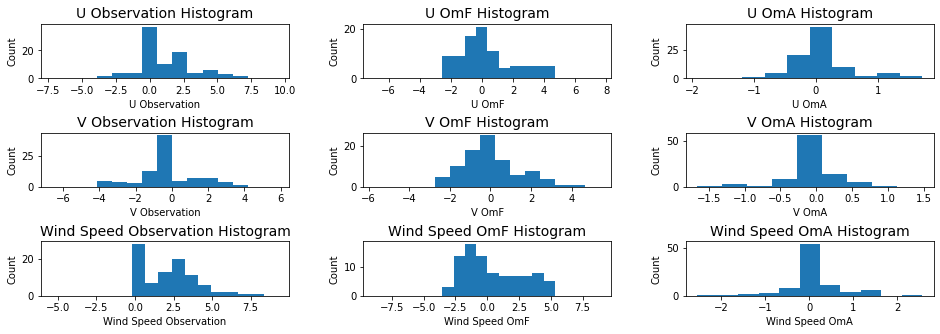

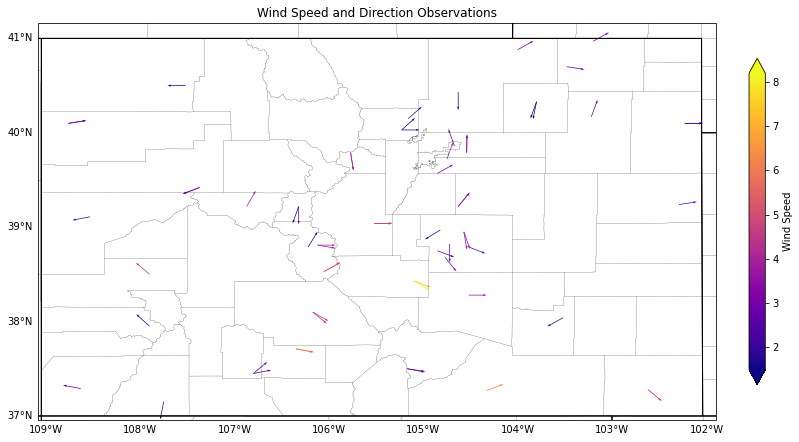

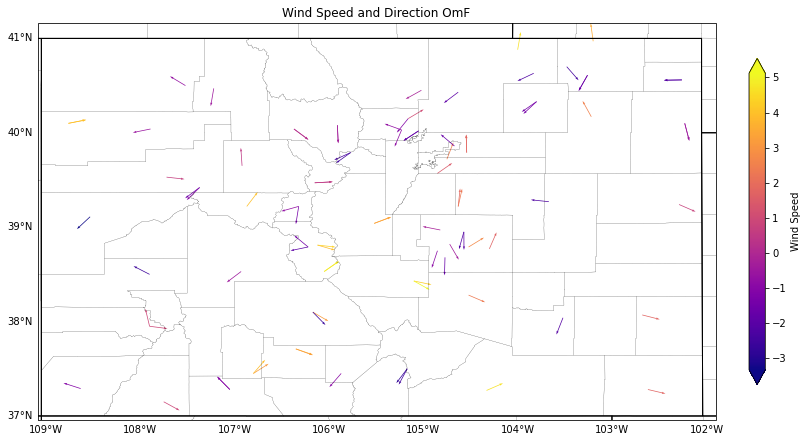

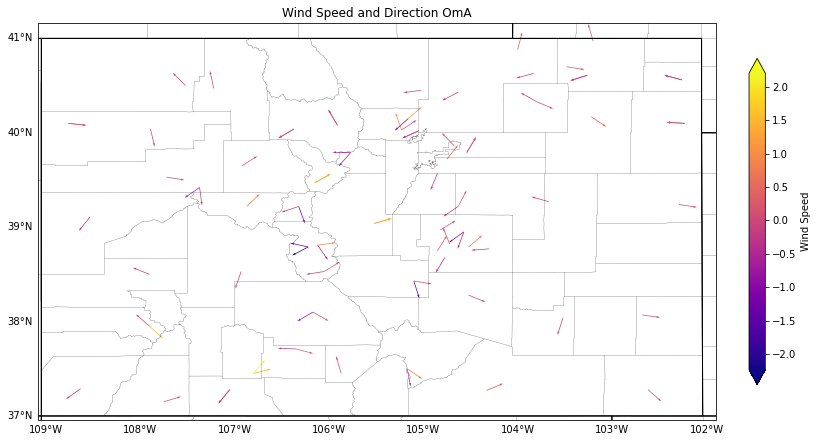

In [11]:
# base_plots(df_anl_fil, df_ges_fil, diag_ges.metadata)
wind_base_plots(df_anl_fil, df_ges_fil, diag_ges.metadata)

# Exploring time series plots

In [14]:
# Get the yesterdays date
today = datetime.today()
yesteryesterday = today - timedelta(days=1)

# Format date
date = yesteryesterday.strftime('%Y%m%d')
print(date)

20240702


In [15]:
rrfs_data_fp = "/lfs4/BMC/nrtrr/NCO_dirs/v0.8.8/com/prod/"
rtma_data_fp = "/lfs4/BMC/nrtrr/NCO_dirs/rtma.v0.8.8/com/prod/RTMA_CONUS." + date

## Dataframe for reference

In [16]:
test_hr = '20'
test_fp = f"{rtma_data_fp}/{test_hr}/diag_conv_t_anl.{date}{test_hr}.nc4.gz"
test_df = Conventional(test_fp).get_data()

In [17]:
# station_ids = ['G4CUISJA']
station_ids = None
obs_types = None

# Get a list of strings with all hours of day
var = 't'

In [19]:
# fps, times = get_gsi_fps(rtma_data_fp, var)
fps, times = plt_ts.get_gsi_fps('/lfs4/BMC/nrtrr/NCO_dirs/rtma.v0.8.8/com/prod', anl_or_ges = "ges",
                         var=var, multiday=True)

In [20]:
omfs = plt_ts.get_omfs(fps)

In [21]:
for omf in omfs:
    print(omf)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.23654845356941223
0.16510605812072754
0.08603143692016602
-0.02262163907289505
-0.03458418324589729
-0.13093885779380798
-0.07323652505874634
-0.05057648941874504
0.02544114738702774
0.11967192590236664
0.19630159437656403
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


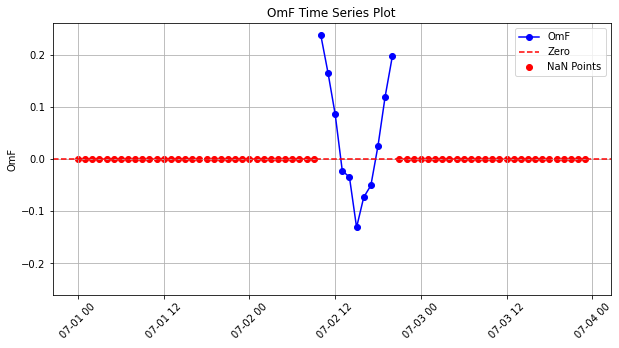

In [23]:
plt_ts.make_plot(omfs, times)